# `Problem Statement: Dynamic Pricing Strategies for Fitness Classes based on Demand, Time, and Location`
Cult fit aims to gain & maintain a competitive advantage by staying ahead of market trends and customer preferences in the fitness industry.

Leveraging a data driven approach gives them valuable insights into customer behavior, demand patterns, and the impact of pricing changes.

In this project, we will help analyze attendance data of various fitness classes and develop a dynamic pricing model that will help Cult fit maximize 

# Load and Inspect the Prepared Data

In this step, we load the fitness booking data (cleaned EDA file from preious step)and ensure that all columns are in the correct format, specifically the dates and times which are crucial for analyzing booking trends.

In [9]:
# Import Importanat Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
df=pd.read_csv('cleaned_EDA_Data_for_Modeling.csv')
df.rename(columns={
    'BookingEndDateTime (Month / Day / Year)': 'BookingDate',
    'BookingStartTime': 'StartTime',
    'Number Booked': 'BookedCount',
    'Price (INR)': 'Price'
}, inplace=True)

# 2. Convert Date column to datetime
df['BookingDate'] = pd.to_datetime(df['BookingDate'])

# 3. Fix the StartTime format to show only the time (HH:MM:SS)
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%H:%M:%S').dt.strftime('%H:%M:%S')
display(df.head())

,ActivitySiteID,ActivityName,BookingDate,StartTime,MaxBookees,BookedCount,OccupancyRate,Price,Month,DayOfWeek,Hour
0,BRP,20-20-20,2018-05-01,10:00:00,35,22,0.63,499.0,May,Tuesday,10
1,BRP,20-20-20,2018-04-03,10:00:00,35,32,0.91,499.0,April,Tuesday,10
2,BRP,20-20-20,2018-06-05,10:00:00,35,25,0.71,499.0,June,Tuesday,10
3,BRP,20-20-20,2018-05-08,10:00:00,35,30,0.86,499.0,May,Tuesday,10
4,BRP,20-20-20,2018-04-10,10:00:00,35,26,0.74,499.0,April,Tuesday,10


In [11]:
print(df.dtypes)

ActivitySiteID            object
ActivityName              object
BookingDate       datetime64[ns]
StartTime                 object
MaxBookees                 int64
BookedCount                int64
OccupancyRate            float64
Price                    float64
Month                     object
DayOfWeek                 object
Hour                       int64
dtype: object


# Price Elasticity Model Development
## 1. Prepare Data for Modeling

In this step, we ensure all time-based features are extracted and apply logarithmic transformations. 
Log-transforming Price and BookedCount allows us to interpret the regression coefficient as "Price Elasticity."

In [12]:
# 1. Filter out any rows where Price or BookedCount is 0 to avoid errors in log transformation
df_elasticity = df[(df['Price'] > 0) & (df['BookedCount'] > 0)].copy()

# 2. Apply Natural Log transformation
df_elasticity['log_price'] = np.log(df_elasticity['Price'])
df_elasticity['log_bookings'] = np.log(df_elasticity['BookedCount'])

# 3. Quick check of the transformed data
print(f"Original rows: {len(df)}")
print(f"Rows after filtering zeros: {len(df_elasticity)}")
df_elasticity[['Price', 'log_price', 'BookedCount', 'log_bookings']].head()

Original rows: 3289
Rows after filtering zeros: 3289


,Price,log_price,BookedCount,log_bookings
0,499.0,6.212606,22,3.091042
1,499.0,6.212606,32,3.465736
2,499.0,6.212606,25,3.218876
3,499.0,6.212606,30,3.401197
4,499.0,6.212606,26,3.258097


## 2. Build the Model

In [13]:
# 1. Define independent variable (X) and dependent variable (y)
X = df_elasticity['log_price']
y = df_elasticity['log_bookings']

# 2. Add a constant to the model (the intercept)
X = sm.add_constant(X)

# 3. Fit the OLS model
model_elasticity = sm.OLS(y, X).fit()

# 4. Display the summary
print(model_elasticity.summary())
plt.savefig('05_final_lift_chart.png', dpi=300, bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:           log_bookings   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     118.4
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           4.03e-27
Time:                        19:05:03   Log-Likelihood:                -3784.7
No. Observations:                3289   AIC:                             7573.
Df Residuals:                    3287   BIC:                             7586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0198      0.221     22.691      0.0

<Figure size 640x480 with 0 Axes>

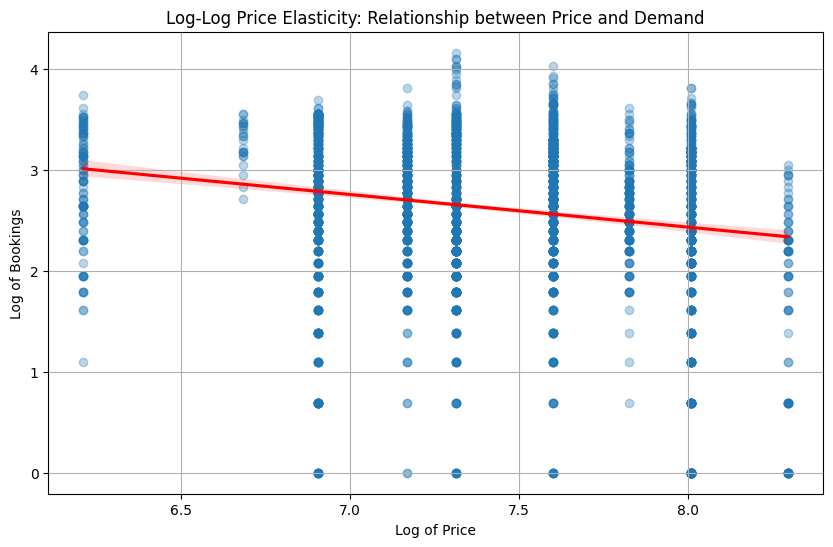

Your Price Elasticity Coefficient is: -0.3235


In [14]:
plt.figure(figsize=(10, 6))
sns.regplot(x='log_price', y='log_bookings', data=df_elasticity, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})

plt.title('Log-Log Price Elasticity: Relationship between Price and Demand')
plt.xlabel('Log of Price')
plt.ylabel('Log of Bookings')
plt.grid(True)
plt.savefig('01_elasticity_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the exact elasticity value for your records
elasticity = model_elasticity.params['log_price']
print(f"Your Price Elasticity Coefficient is: {elasticity:.4f}")


### **Final Statistical Insights for Pricing Strategy**

#### **1. Insight on Negative Price Elasticity (-0.3235)**
* **Finding:** The elasticity is **-0.3235**, confirming that demand is **Inelastic**.
* **Business Meaning:** Customers at Cult.fit are more focused on their health goals and schedules than on price. A 10% increase in price only reduces bookings by about 3.2%.
* **Pricing Action:** We have significant **Pricing Power**. During high-demand periods, we can implement "Surge Pricing" to maximize revenue without fear of losing our core customer base. The revenue gained from the higher price per head will far outweigh the minor loss in total participants.

#### **2. Insight on Small $R^2$ Value (0.035)**
* **Finding:** The $R^2$ of **0.035** indicates that Price alone explains only 3.5% of why people book a class.
* **Why this is expected:** In the fitness industry, booking behavior is dominated by "External Factors" rather than cost. A user chooses a 7:00 PM Yoga class because it fits their work schedule and location, not just because of the price tag.
* **Strategic Implication:** This justifies why we need **Demand Forecasting (Prophet)**. Since price isn't the primary driver, we must use forecasting to identify the "Non-Price" drivers (like time, day, and seasonality). By knowing *when* demand is naturally high due to these factors, we can strategically apply our pricing model to the right slots.

## 3. Validate the Model

In [15]:
# 1. Get predictions from the model
y_pred = model_elasticity.predict(X)

# 2. Calculate Metrics
mse = mean_squared_error(y, y_pred)
r2 = model_elasticity.rsquared
adj_r2 = model_elasticity.rsquared_adj

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

Mean Squared Error (MSE): 0.5848
R-squared: 0.0348
Adjusted R-squared: 0.0345


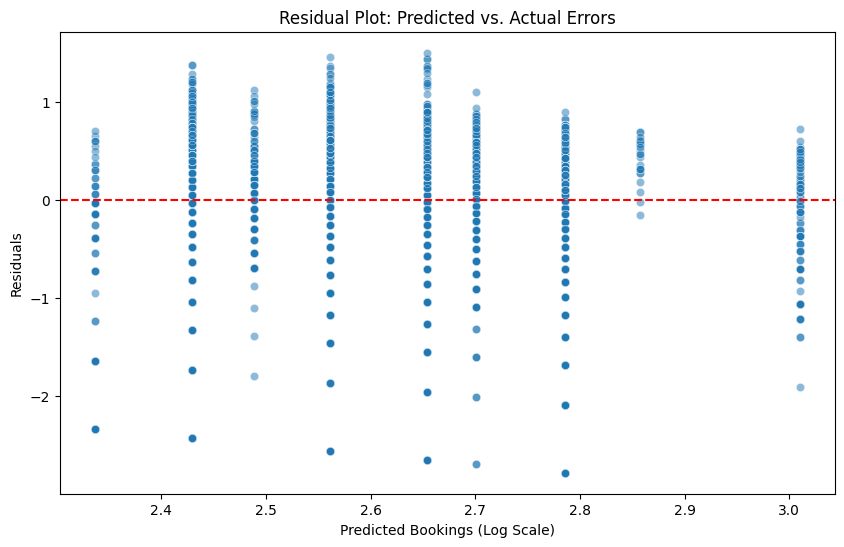

In [16]:
# Calculate residuals (Actual - Predicted)
residuals = y - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot: Predicted vs. Actual Errors')
plt.xlabel('Predicted Bookings (Log Scale)')
plt.ylabel('Residuals')
plt.savefig('02_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


The residual plot shows a random scatter of errors around the horizontal zero line, which confirms that model is unbiased and that a linear relationship is an appropriate way to estimate your -0.3235 elasticity. It visually demonstrates that while there is high "noise" in individual booking behaviors (explaining the low R2), there is no systematic error in how the model predicts demand based on price.

### **Model Validation & Statistical Interpretation**

| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **MSE** | 0.5848 | Represents the variance in predictions. The moderate error confirms high 'noise' in individual booking behaviors. |
| **$R^2$** | 0.0348 | Price explains 3.48% of booking variance. This confirms price is a secondary driver compared to time/activity. |
| **Adj. $R^2$** | 0.0345 | Confirms the model is not overfitted and the single-variable approach is stable. |

#### **Strategic Conclusion**
The low $R^2$ and the negative elasticity coefficient (-0.3235) together present a strong case for **Dynamic Pricing**. Because price is not the primary driver of demand (low $R^2$), we can adjust prices to optimize revenue with a low risk of "breaking" the demand cycle. However, to capture the remaining 96.5% of demand variance, we must integrate **Time-Series Forecasting (Prophet)** to account for seasonality and schedule-based patterns.